# Imports


In [1]:
from google.colab import drive
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
from tqdm import tqdm

In [2]:
drive.mount('/content/drive')

# Load the images
data_dir = '/content/drive/MyDrive/New_HHD_AgeSplit'
train_dir = data_dir + '/train'
val_dir = data_dir + '/val'
test_dir = data_dir + '/test'

# Load the CSV file
csv_dir = data_dir + '/NewAgeSplit.csv'
labels_data = pd.read_csv(csv_dir)

Mounted at /content/drive


# Training


## Loading Images From Drive


In [3]:
# Function to load images and labels based on the CSV
def load_images_and_labels_from_csv(data_dir, dataset_type, labels_df):
    subset_df = labels_df[labels_df['Set'] == dataset_type]
    images = []
    labels = []

    print(f"Loading {dataset_type} data...")
    for _, row in tqdm(subset_df.iterrows(), total=len(subset_df), desc=f"Processing {dataset_type} images"):
        img_path = os.path.join(data_dir, row['File'])
        if os.path.exists(img_path):
            # Load and preprocess the image
            img = tf.keras.utils.load_img(img_path, target_size=(128, 128))  # Resize images
            img = tf.keras.utils.img_to_array(img) / 255.0  # Normalize pixel values
            images.append(img)
            labels.append(row['Age'])
        else:
            print(f"Image not found: {img_path}")

    return np.array(images), np.array(labels)

In [4]:
# Load train, val, and test datasets
X_train, y_train = load_images_and_labels_from_csv(train_dir, 'train', labels_data)
X_val, y_val = load_images_and_labels_from_csv(val_dir, 'val', labels_data)
X_test, y_test = load_images_and_labels_from_csv(test_dir, 'test', labels_data)

Loading train data...


Processing train images: 100%|██████████| 669/669 [05:29<00:00,  2.03it/s]


Loading val data...


Processing val images: 100%|██████████| 178/178 [01:34<00:00,  1.88it/s]


Loading test data...


Processing test images: 100%|██████████| 200/200 [02:20<00:00,  1.42it/s]


In [ ]:
# Save datasets
# np.save('X_train.npy', X_train)
# np.save('y_train.npy', y_train)
# np.save('X_val.npy', X_val)
# np.save('y_val.npy', y_val)
# np.save('X_test.npy', X_test)
# np.save('y_test.npy', y_test)

# print("Datasets saved successfully.")

## Load npy Files From Drive


In [ ]:
# Load datasets from the folder
# X_train = np.load('/content/drive/MyDrive/HHD_AgeSplit/basic_cnn_training/X_train.npy')
# y_train = np.load('/content/drive/MyDrive/HHD_AgeSplit/basic_cnn_training/y_train.npy')
# X_val = np.load('/content/drive/MyDrive/HHD_AgeSplit/basic_cnn_training/X_val.npy')
# y_val = np.load('/content/drive/MyDrive/HHD_AgeSplit/basic_cnn_training/y_val.npy')
# X_test = np.load('/content/drive/MyDrive/HHD_AgeSplit/basic_cnn_training/X_test.npy')
# y_test = np.load('/content/drive/MyDrive/HHD_AgeSplit/basic_cnn_training/y_test.npy')

## Initialize Training


In [5]:
# Normalize labels using MinMaxScaler
scaler = MinMaxScaler()
y_train = scaler.fit_transform(y_train.reshape(-1, 1)).flatten()
y_val = scaler.transform(y_val.reshape(-1, 1)).flatten()
y_test = scaler.transform(y_test.reshape(-1, 1)).flatten()

In [6]:
# Data Augmentation for the training set
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

In [7]:
# Validation and test data are not augmented
val_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()

In [8]:
# Prepare data generators
train_generator = train_datagen.flow(X_train, y_train, batch_size=32)
val_generator = val_datagen.flow(X_val, y_val, batch_size=32)
test_generator = test_datagen.flow(X_test, y_test, batch_size=32)

In [9]:
# Define the CNN Model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)), # Extract spatial features from the images
    MaxPooling2D((2, 2)), # Reduce dimensionality while retaining important features
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(), # Converts the 2D feature maps into a 1D vector
    Dense(128, activation='relu'), # Fully connected layers for learning non-linear combinations of the features
    Dropout(0.5), # Prevents overfitting by randomly dropping neurons during training.
    Dense(1, activation='linear')  # Single neuron for regression output
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Save the best model during training
checkpoint = ModelCheckpoint(
    '/content/drive/MyDrive/New_HHD_AgeSplit/basic_cnn_training/1.keras', monitor='val_loss', save_best_only=True, mode='min'
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## Train

In [10]:
# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    callbacks=[checkpoint]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 13s 309ms/step - loss: 4.0599 - mae: 0.9347 - val_loss: 0.0233 - val_mae: 0.0973
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 140ms/step - loss: 0.0244 - mae: 0.1020 - val_loss: 0.0222 - val_mae: 0.1133
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 178ms/step - loss: 0.0224 - mae: 0.1031 - val_loss: 0.0235 - val_mae: 0.1232
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - loss: 0.0242 - mae: 0.1107 - val_loss: 0.0225 - val_mae: 0.1156
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 143ms/step - loss: 0.0269 - mae: 0.1124 - val_loss: 0.0218 - val_mae: 0.1068
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 171ms/step - loss: 0.0258 - mae: 0.1049 - val_loss: 0.0224 - val_mae: 0.0962
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 139ms/step - loss: 0.0216 - mae: 0.1030 - val_loss: 0.0217 - val_mae: 0.1015
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - loss: 0.0240 - mae: 0.1064 - val_loss: 0.0237 - val_mae: 0.1243
Epoch 9/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - l

# Evaluation


## Load Model

In [ ]:
# Load the best model
model = tf.keras.models.load_model('/content/drive/MyDrive/New_HHD_AgeSplit/basic_cnn_training/1.keras')

## Run Evaluations


In [11]:
# Evaluate the model on the test set
test_loss, test_mae = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}, Test MAE: {test_mae}")

# Calculate denormalized MAE
denormalized_mae = scaler.inverse_transform([[test_mae]])[0][0]
print(f"Denormalized Test MAE: {denormalized_mae}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - loss: 0.0235 - mae: 0.1312
Test Loss: 0.022228825837373734, Test MAE: 0.12978284060955048
Denormalized Test MAE: 18.77197577059269


In [12]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Example usage:
predicted = model.predict(test_generator)
predicted_denormalized = scaler.inverse_transform(predicted).flatten()
true_denormalized = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

mape = mean_absolute_percentage_error(true_denormalized, predicted_denormalized)
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step
Mean Absolute Percentage Error (MAPE): 75.73%


In [13]:
from sklearn.metrics import mean_squared_error

rmse = np.sqrt(mean_squared_error(true_denormalized, predicted_denormalized))
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

Root Mean Squared Error (RMSE): 13.94


In [14]:
from sklearn.metrics import r2_score

r2 = r2_score(true_denormalized, predicted_denormalized)
print(f"R-Squared (R2): {r2:.4f}")

R-Squared (R2): -0.5508


In [15]:
def percent_within_threshold(y_true, y_pred, threshold):
    errors = np.abs(y_true - y_pred)
    within_threshold = np.sum(errors <= threshold)
    return (within_threshold / len(y_true)) * 100

within_2_years = percent_within_threshold(true_denormalized, predicted_denormalized, 2)
within_5_years = percent_within_threshold(true_denormalized, predicted_denormalized, 5)
within_10_years = percent_within_threshold(true_denormalized, predicted_denormalized, 10)
within_20_years = percent_within_threshold(true_denormalized, predicted_denormalized, 20)

print(f"Percentage Within ±2 Years: {within_2_years:.2f}%")
print(f"Percentage Within ±5 Years: {within_5_years:.2f}%")
print(f"Percentage Within ±10 Years: {within_10_years:.2f}%")

Percentage Within ±2 Years: 5.50%
Percentage Within ±5 Years: 15.50%
Percentage Within ±10 Years: 36.50%


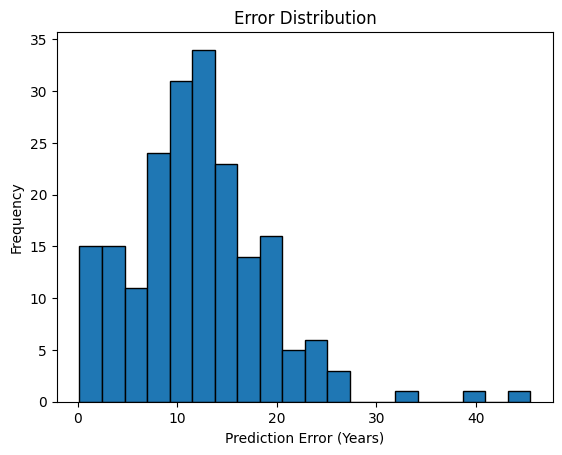

In [16]:
import matplotlib.pyplot as plt

errors = abs(true_denormalized - predicted_denormalized)

plt.hist(errors, bins=20, edgecolor='black')
plt.title('Error Distribution')
plt.xlabel('Prediction Error (Years)')
plt.ylabel('Frequency')
plt.show()

In [17]:
print("Model Performance Metrics:")
print(f"Mean Absolute Error (MAE): {denormalized_mae:.2f} years")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f} years")
print(f"R-Squared (R2): {r2:.4f}")
print(f"Percentage Within ±5 Years: {within_5_years:.2f}%")
print(f"Percentage Within ±10 Years: {within_10_years:.2f}%")
print(f"Max Error: {np.max(errors):.2f} years")
print(f"Median Error: {np.median(errors):.2f} years")
print(f"Cumulative Error ≤ 5 Years (%) {np.mean(errors <= 5) * 100:.2f}")

Model Performance Metrics:
Mean Absolute Error (MAE): 18.77 years
Mean Absolute Percentage Error (MAPE): 75.73%
Root Mean Squared Error (RMSE): 13.94 years
R-Squared (R2): -0.5508
Percentage Within ±5 Years: 15.50%
Percentage Within ±10 Years: 36.50%
Max Error: 45.47 years
Median Error: 11.66 years
Cumulative Error ≤ 5 Years (%) 15.50


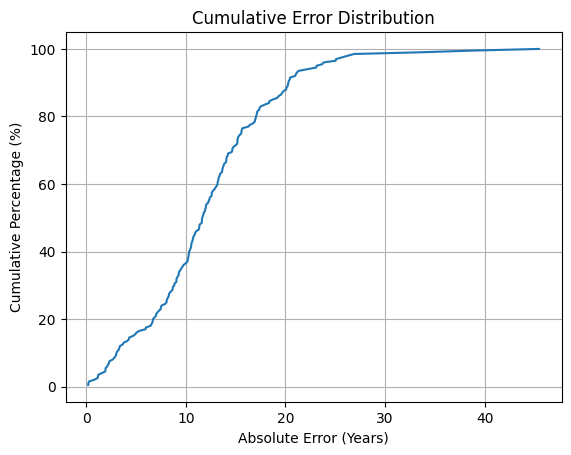

In [18]:
errors_sorted = np.sort(np.abs(errors))
cumulative_percentage = np.arange(1, len(errors_sorted) + 1) / len(errors_sorted) * 100

plt.plot(errors_sorted, cumulative_percentage)
plt.title('Cumulative Error Distribution')
plt.xlabel('Absolute Error (Years)')
plt.ylabel('Cumulative Percentage (%)')
plt.grid(True)
plt.show()

### Image Prediction


In [ ]:
# Predict on new data
def predict_age(image_path):
    img = tf.keras.utils.load_img(image_path, target_size=(128, 128))
    img_array = tf.keras.utils.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    predicted_age = model.predict(img_array)[0][0]
    return scaler.inverse_transform([[predicted_age]])[0][0]

# Example prediction
test_image_path = '/content/drive/My Drive/your_test_image.jpg'
predicted_age = predict_age(test_image_path)
print(f"Predicted Age: {predicted_age}")